# Image Segmentation with Deep Learning




Author: Hayden Suwaed

Email: haidersuwaed@gmail.com



Date: Apr-1-2023









## Table of Contents
[1. Introduction](#Intorduction) <br>
[2. Modeling](#Modeling) <br>
[3. Kernels](#Kernels) <br>
[4. Pooling](#Pooling) <br>
[5. Conclusions](#Conclusions)


## Introduction <a class = 'anchor' id = 'Introduction'></a>

"Healing is a matter of time, but it is sometimes also a matter of opportunity." -*Hippocrates*

Brain tumor segmentation is a critical task in medical image analysis, which entails the precise delineation of tumor regions from healthy brain tissues in magnetic resonance imaging (MRI) scans. Accurate segmentation is vital for diagnosis, treatment planning, and monitoring the progress of patients with brain tumors. Deep learning has emerged as a powerful tool for tackling this challenging problem, with Convolutional Neural Networks (CNNs) and other sophisticated architectures exhibiting remarkable performance in identifying, localizing, and classifying different tumor sub-regions.**The primary goal of utilizing deep learning algorithms for brain tumor segmentation is to achieve unparalleled accuracy in detecting and delineating tumor regions, thereby facilitating timely diagnosis and personalized treatment plans for improved patient outcomes.**

## Data Collection and Description <a class = 'anchor' id = 'Data Collection and Description'></a>



In this study, we will utilize a dataset consisting of images and their corresponding masks in the Joint Photographic Experts Group (JPEG) format. The dataset was procured and preprocessed by Southern Medical University, located in Guangzhou, Guangdong, China. The dataset was originally released on April 2, 2017.


The brain tumor dataset comprises 3,064 T1-weighted contrast-enhanced images derived from 233 patients diagnosed with three distinct brain tumor types: meningioma (708 slices), glioma (1,426 slices), and pituitary tumor (930 slices). Owing to repository file size constraints, the dataset has been partitioned into four subsets and compressed into four separate .zip files, each containing 766 slices. Additionally, the dataset includes indices for 5-fold cross-validation to facilitate model evaluation and comparison.



Check out the dataset that have bee used for this project [Here](https://drive.google.com/drive/folders/1nAu70XoU7Wln8nY1OC7zhfr7n5f0rYlf?usp=share_link)

In [1]:
#Import different and necessary libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, GaussianNoise
from tensorflow.keras.models import Model
# from focal_loss import BinaryFocalLoss


import os
import random
import numpy as np
import pandas as pd
from glob import glob
import pandas as pd

 
from tqdm import tqdm 
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

The following code utilizes the TensorFlow library to detect and list the physical and logical graphics processing units (GPUs) available in the system. It then sets the memory growth parameter to True for each available GPU, which allows for dynamic allocation of only necessary GPU memory during computation. The code is enclosed in a try-except block to handle any runtime errors. Finally, the code prints the number of physical and logical GPUs detected in the system.

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Here we set the values of `IMG_WIDTH`, `IMG_HEIGHT`, and `IMG_CHANNELS` to 128, 128, and 3, respectively. These variables are commonly used in image processing and computer vision applications to define the dimensions and number of channels of an image.

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

The `seed` variable is set to 42, which is a commonly used value in random number generation. The `batch_size` is set to 10, which specifies the number of samples to use for each training update. The `lr` variable defines the learning rate of the optimizer and is set to 1e-4, and the `optimizer` is defined using the Adam optimizer from the Keras library with the specified learning rate. `num_epochs` is set to 60, which specifies the number of times the training process should iterate over the entire dataset. Finally,`model_path` and `csv_path` specify the file paths for saving the best model and logging the training metrics, respectively.

In [ ]:
seed=42
batch_size = 10
lr = 1e-4
optimizer =tf.keras.optimizers.Adam(lr)
num_epochs = 60
model_path = os.path.join("files", "best_model.h5")
csv_path = os.path.join("files", "log.csv")

## Loading and Preprocessing Data


Here wedefine a function named `load_dataset` that takes a `path` argument, which specifies the location of the dataset images and masks. The function also allows for specifying the `val_split` and `test_split` proportions for splitting the dataset into validation and test sets. The function first retrieves the images and masks from the specified paths using `glob` and sorts them. It then calculates the validation and test set sizes and splits the data accordingly using `train_test_split` from the Scikit-learn library. Finally, the function returns the training, validation, and test data as tuples of `(images, masks)` for each set.

In [ ]:
def load_dataset(path, val_split=0.1, test_split=0.05, image_format="jpg"):
    """
    Loads a dataset of images and masks from a specified path, and returns a tuple containing training, validation, and 
    test sets of data. 
    
    Parameters:
    path (str): The path to the dataset directory
    val_split (float, optional): The proportion of the dataset to use for validation. Defaults to 0.1.
    test_split (float, optional): The proportion of the dataset to use for testing. Defaults to 0.05.
    image_format (str, optional): The file format of the images in the dataset. Defaults to "jpg".
    
    Returns:
    Tuple: A tuple containing three sets of data, each represented as a tuple of two lists. 
           The first list contains file paths to the images in the dataset, 
           and the second list contains file paths to the corresponding masks. 
           The three sets of data are: (training data, validation data, test data)
    """
        
    image_format = image_format
    images = sorted(glob(os.path.join(path, "images", f"*.{image_format}")))
    masks = sorted(glob(os.path.join(path, "masks", f"*.{image_format}")))

    val_split_size = int(len(images) * val_split)
    test_split_size = int(len(images) * test_split)

    train_x, valid_x = train_test_split(images, test_size=val_split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=val_split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

As you can see, `np.random.seed(42)` sets the NumPy random seed to 42, which ensures that the same sequence of random numbers will be generated on each run. `tf.random.set_seed(42)` sets the TensorFlow random seed to 42, which ensures that the model will be initialized with the same set of random weights on each run, allowing for reproducibility of results.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

We are checking if a directory named 'files/' exists, and creates one if it does not exist, using the `os` module. The following commented line is used to print the current working directory path using the `pwd` command.

In [ ]:
if os.path.exists('files/') == False:
  os.mkdir('files/')

# os.chdir('/content/drive/MyDrive/BT_Seg_Unet')
!pwd

/content


`dataset_path`, `image_path`, and `mask_path` variables store the paths to the dataset and the corresponding image and mask directories. The `load_dataset()` function is used to load and split the data into training, validation, and test sets and returns them as tuples of `(images, masks)` for each set. The returned values are then unpacked and stored in `(train_x, train_y)`, `(valid_x, valid_y)`, `(test_x, test_y)` variables.

In [ ]:
dataset_path = "/content/drive/MyDrive/Brain_MRI_Segmentation/dataset"
image_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/images/'
mask_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/masks/'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path, image_format='jpg')

Here we mount the Google Drive to the Colaboratory notebook instance in order to access and read/write files from/to the Google Drive file system.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Sanity check
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 2605 - 2605
Valid: 306 - 306
Test : 153 - 153


The below code creates a pandas DataFrame object `train_x_df` containing the paths to the training images, splits the paths by '/' using `str.split()` function, stores the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [ ]:
train_x_df=pd.DataFrame(train_x, columns=['path'])
train_x_df = train_x_df.path.str.split("/", expand=True)
train_x_df[2]=train_x_df[2].sort_values()
train_x_df.head()

,0,1,2,3,4,5,6,7
0,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,103582_pituitary_1634.jpg
1,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,101724_pituitary_1933.jpg
2,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,104684_pituitary_1104.jpg
3,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,112847_pituitary_70.jpg
4,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,MR026175E_glioma_337.jpg


The following code creates a pandas DataFrame object containing the paths to the training masks and splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorting the column containing the names of the subdirectories in ascending order.

In [ ]:
train_y_df=pd.DataFrame(train_y, columns=['path'])
train_y_df = train_y_df.path.str.split("/", expand=True)
train_y_df[2]=train_y_df[2].sort_values()
train_y_df.head()

,0,1,2,3,4,5,6,7
0,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,103582_pituitary_1634.jpg
1,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,101724_pituitary_1933.jpg
2,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,104684_pituitary_1104.jpg
3,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,112847_pituitary_70.jpg
4,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,MR026175E_glioma_337.jpg


Here we create a pandas DataFrame object containing the paths to the validation images, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [ ]:
valid_x_df=pd.DataFrame(valid_x, columns=['path'])
valid_x_df = valid_x_df.path.str.split("/", expand=True)
valid_x_df[2]=valid_x_df[2].sort_values()
valid_x_df.head()

,0,1,2,3,4,5,6,7
0,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,112552_meningioma_88.jpg
1,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,102075_glioma_739.jpg
2,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,112649_pituitary_2472.jpg
3,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,97890_pituitary_67.jpg
4,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,images,97607_meningioma_477.jpg


Here we create a pandas DataFrame object containing the paths to the validation masks, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [ ]:
valid_y_df=pd.DataFrame(valid_y, columns=['path'])
valid_y_df = valid_y_df.path.str.split("/", expand=True)
valid_y_df[2]=valid_y_df[2].sort_values()
valid_y_df.head()

,0,1,2,3,4,5,6,7
0,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,112552_meningioma_88.jpg
1,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,102075_glioma_739.jpg
2,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,112649_pituitary_2472.jpg
3,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,97890_pituitary_67.jpg
4,,content,drive,MyDrive,Brain_MRI_Segmentation,dataset,masks,97607_meningioma_477.jpg


## Data Augmentation


Here we need to initialize a random seed and imports the `ImageDataGenerator` class from the Keras library to define `img_data_gen_args` and `mask_data_gen_args` which specify the data augmentation parameters for images and masks, respectively. Two `ImageDataGenerator` objects are then created using these dictionaries. These generators are used to flow data from the dataframes of training and validation images and masks into the model. The `flow_from_dataframe()` function creates a generator that yields batches of augmented images and masks during training and validation. The `color_mode` parameter specifies the color channel format of the images and masks, and the `target_size` parameter defines the desired size of the images and masks after augmentation.

In [ ]:
seed=42
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     brightness_range=[0.1,1.2],
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     rescale=1/255.) 

mask_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     brightness_range=[0.1,1.2],
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0)) 
image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(X_train, augment=True, seed=seed)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(Y_train, augment=True, seed=seed)

image_generator = image_data_generator.flow_from_dataframe(dataframe=train_x_df, x_col=7, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
mask_generator = mask_data_generator.flow_from_dataframe(dataframe=train_y_df, x_col=7, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

valid_img_generator = image_data_generator.flow_from_dataframe(dataframe=valid_x_df, x_col=7, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
valid_mask_generator = mask_data_generator.flow_from_dataframe(dataframe=valid_y_df, x_col=7, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2605 validated image filenames.
Found 2605 validated image filenames.
Found 306 validated image filenames.
Found 306 validated image filenames.


In [ ]:
# Sanity check
print(f"Train: {len(image_generator)}")
print(f"Valid: {len(valid_img_generator)}")

Train: 261
Valid: 31


In [ ]:
# check image & mask dimensions
image_generator[1][0].shape, mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

In [ ]:
valid_img_generator[1][0].shape, valid_mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

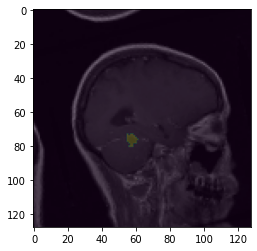

In [ ]:
# sanity check
# np.random.seed(42)
i=np.random.randint(0, len(image_generator) - 1)
j=np.random.randint(0, batch_size - 1)
plt.imshow(image_generator[i][j])
plt.imshow(mask_generator[i][j], alpha=0.2)

Here we define a custom generator function `my_image_mask_generator()` that takes `image_generator` and `mask_generator` as input. The `zip()` function is used to combine the images and masks from the generators into pairs. The generator then yields these pairs of augmented images and masks during training.

In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

The code below initializes the training and validation datasets using the custom generator function `my_image_mask_generator()`. The `train_dataset` is created by calling `my_image_mask_generator()` with the `image_generator` and `mask_generator`, while valid_dataset is created by calling `my_image_mask_generator()` with `valid_img_generator` and `valid_mask_generator`. These generators yield pairs of augmented images and masks during training and validation.

In [ ]:
train_dataset = my_image_mask_generator(image_generator, mask_generator)
valid_dataset = my_image_mask_generator(valid_img_generator, valid_mask_generator)

We need to calculate the number of batches in the training and validation datasets using `steps_per_epoch` and `val_steps` variables, respectively. `steps_per_epoch` is calculated by multiplying the length of `train_x` by 3 and dividing the result by batch_size. Similarly, `val_steps` is calculated by multiplying the length of `valid_x` by 3 and dividing the result by `batch_size`. These variables are used to specify the number of training and validation steps during model training.

In [ ]:
steps_per_epoch = 3*(len(train_x))//batch_size
val_steps = 3*(len(valid_x))//batch_size

## Evaluation Metrics
   **- Dice Coefficient (F1 Score)**\
   **- Intersection-Over-Union (Jaccard Index)**

This function defines two functions for calculating the Dice coefficient and loss, respectively. The `dice_coef()` function calculates the Dice coefficient between the true and predicted masks. The function first flattens the input masks using `tf.keras.layers.Flatten()`, computes the intersection between the true and predicted masks using element-wise multiplication and `tf.reduce_sum()`, and returns the Dice coefficient using the formula `(2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)`, where `smooth` is a small value added to the denominator to avoid division by zero. The `dice_loss()` function calculates the dice loss by subtracting the Dice coefficient from 1.0.

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Modeling

In this project, we will use a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg called **Unet.**

**U-Net** is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network.

 
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"
     align="middle"
     width=1000 />

## Convolutional Neural Networks

Convolutional neural networks are a deep learning algorithm similar to other neural network structures consisting of an input layer, an output layer, and one or many hidden layers. CNNs are commonly used in Computer vision for image classification, image segmentation and medical image processing. The image below shows the structure of a CNN model.


<img src=https://www.researchgate.net/publication/336805909/figure/fig2/AS:817888827027462@1572011300841/The-proposed-CNN-model-architecture.ppm align="middle" 
     width="800" />

## Kernels
**Kernels** can refer to a central component of an operating system that manages system resources, a function used in machine learning to transform data into a more useful representation, or a small matrix used in image processing to apply operations on an image.


**Kernels:** kernels are the size of the windows that are slided on the input images. We Implement convolutions on the pixels in the underlying windows. This helps to learn local features of the images. However, we do not need to implement convolutions on all the pixels on the image and we can jump a few pixels by using the hyperparameter Stride. Stride defines the number of pixels we jump each time we move the window. For example in the gif below, the kernel size is 3x3 and the stride is 1.

<img src="https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif" 
     align="middle" 
     width="300" />

## Pooling
**Pooling** is a technique in deep learning used to reduce the spatial dimensions of feature maps, thereby reducing the computational complexity of subsequent layers. It is a form of down-sampling that reduces the size of the input by summarizing nearby features.

**Max pooling** is a specific type of pooling operation where the maximum value in each pooling window is selected as the output value. The pooling window is typically a square or rectangular region of the input feature map.

Max pooling is commonly used in convolutional neural networks (CNNs) for computer vision tasks such as image classification and object detection. It helps to extract the most important features from the input while reducing the spatial dimensions of the feature map.v


<img src="https://miro.medium.com/v2/resize:fit:700/1*FHPUtGrVP6fRmVHDn3A7Rw.png" 
     align="middle" 
     width="600" />

Convolutional encoder-decoder architecture combines the principles of both convolutional neural networks (CNNs) and encoder-decoder networks. It can be used for both feature extraction and segmentation tasks. The encoder extracts high-level features from the input image, while the decoder maps those features back to the original image size and produces a segmentation mask. It has been shown to be effective for a wide range of tasks such as image segmentation, image denoising, and image super-resolution.


And here we will now combine the sturcture of a autoencoder and a **U-Net** is an encoder-decoder segmentation network with skip connections as our model.

<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/6114d9b889ba55c2ce882f8a_tVEj_AI9vFj89ZW6G21JHR2r6ZrZ18cvB6lt24-KeGmp9HozQwWACebWAbBJF4hVMQKxh_cMXkmtO2yJrfO3bkp-WNrRa-nTFBM8NPqI0_A3uz6V7hg_-MDy67NgTrzqcg6m-r93.png"
     align="middle"
     width= 800/>

The below defines a U-Net architecture for image segmentation. The architecture consists of encoder and decoder blocks, which are defined using the `encoder_block()` and `decoder_block()` functions, respectively. The conv_block() function defines a convolutional block consisting of two convolutional layers with ReLU activation and dropout. The `build_unet()` function defines the entire U-Net architecture using input dimensions of `IMG_WIDTH`, `IMG_HEIGHT`, and `IMG_CHANNELS`. The model includes an output layer with a single sigmoid activation unit. The summary of the model is printed using `model.summary()`.

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, activation = "relu", kernel_initializer='he_normal', padding="same")(inputs)
    x = Conv2D(num_filters, 3, activation = "relu", kernel_initializer='he_normal', padding="same")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    p = Dropout(0.4)(p)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = Dropout(0.4)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 48)
    s2, p2 = encoder_block(p1, 112)
    s3, p3 = encoder_block(p2, 240)
    s4, p4 = encoder_block(p3, 496)

    b1 = conv_block(p4, 1008)

    d1 = decoder_block(b1, s4, 496)
    d2 = decoder_block(d1, s3, 140)
    d3 = decoder_block(d2, s2, 112)
    d4 = decoder_block(d3, s1, 48)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = build_unet((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 48  20784       ['conv2d[0][0]']                 
                                )                                                              

As you can see, we compile the U-Net model using the Adam optimizer with learning rate `lr`, binary cross-entropy loss function, and four evaluation metrics. The `dice_coef()` function is used to calculate the Dice coefficient between the predicted and true masks. The `accuracy` metric is used to evaluate the accuracy of the model. The `BinaryIoU()` function is used to calculate the binary intersection over union (IoU) metric with a threshold of 0.5.

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coef,'accuracy', tf.keras.metrics.BinaryIoU(threshold=0.5)])

We need to define four callbacks to be used during model training. The `ModelCheckpoint()` callback saves the best model based on the validation loss during training. The `ReduceLROnPlateau()` callback reduces the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs. The `CSVLogger()` callback logs the training and validation metrics to a CSV file. The `EarlyStopping()` callback stops the training if the validation loss does not improve for 10 epochs and does not restore the best weights.

In [ ]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.CSVLogger(csv_path),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

And here we need to train the U-Net model using the `fit()` method. The training data is provided as `train_dataset`, with `steps_per_epoch` steps per epoch and `num_epochs` epochs. The validation data is provided as `valid_dataset`, with `steps_per_epoch` validation steps. The `callbacks` defined earlier are also used during training. The resulting model is returned and assigned to the `model` variable.

In [ ]:
model = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=valid_dataset,
        validation_steps=steps_per_epoch,
        callbacks=callbacks
    )

Epoch 1/60
781/781 [==============================] - ETA: 0s - loss: 0.0918 - dice_coef: 0.0810 - accuracy: 0.9780 - binary_io_u: 0.4897
Epoch 1: val_loss improved from inf to 0.10109, saving model to files/best_model.h5
781/781 [==============================] - 1116s 1s/step - loss: 0.0918 - dice_coef: 0.0810 - accuracy: 0.9780 - binary_io_u: 0.4897 - val_loss: 0.1011 - val_dice_coef: 0.1062 - val_accuracy: 0.9784 - val_binary_io_u: 0.4892 - lr: 1.0000e-04
Epoch 2/60
781/781 [==============================] - ETA: 0s - loss: 0.0667 - dice_coef: 0.1536 - accuracy: 0.9800 - binary_io_u: 0.5034
Epoch 2: val_loss improved from 0.10109 to 0.06115, saving model to files/best_model.h5
781/781 [==============================] - 208s 267ms/step - loss: 0.0667 - dice_coef: 0.1536 - accuracy: 0.9800 - binary_io_u: 0.5034 - val_loss: 0.0611 - val_dice_coef: 0.2730 - val_accuracy: 0.9789 - val_binary_io_u: 0.6344 - lr: 1.0000e-04
Epoch 3/60
781/781 [==============================] - ETA: 0s - lo

The function below is plotting the train and validation accuracy, loss, dice coefficient, and Intersection over Union (IoU) score of a trained Unet model. It takes the number of epochs and model history data as input, and creates a plot with four subplots. The x-axis of all subplots represents the number of epochs and the y-axis represents the corresponding accuracy, loss, dice coefficient, and IoU value. The plot also includes legends to distinguish the training and validation results of each metric. The function uses matplotlib to create the plot and returns None.

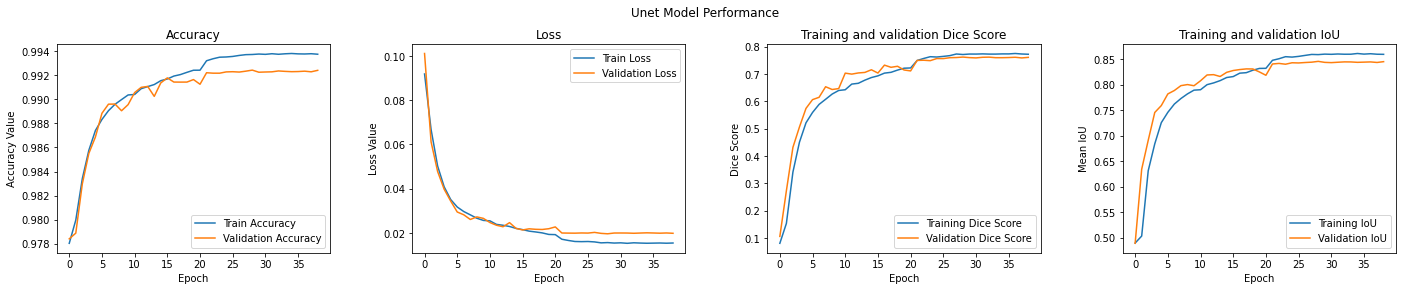

In [ ]:
# plot train, validation Accuracy, Loss, Dice-coef and IOU
num_epochs = len(model.history['accuracy'])
step = 2
if num_epochs > 35:
    step = 5

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
t = f.suptitle('Unet Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,num_epochs))
ax1.plot(epoch_list, model.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, num_epochs, step))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, num_epochs, step))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

epoch_list = list(range(0,num_epochs))
ax3.plot(epoch_list, model.history['dice_coef'], label='Training Dice Score')
ax3.plot(epoch_list, model.history['val_dice_coef'], label='Validation Dice Score')
ax3.set_xticks(np.arange(0, num_epochs, step))
ax3.set_ylabel('Dice Score')
ax3.set_xlabel('Epoch')
ax3.set_title('Training and validation Dice Score')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, model.history['binary_io_u'], label='Training IoU')
ax4.plot(epoch_list, model.history['val_binary_io_u'], label='Validation IoU')
ax4.set_xticks(np.arange(0, num_epochs, step))
ax4.set_ylabel('Mean IoU')
ax4.set_xlabel('Epoch')
ax4.set_title('Training and validation IoU')
l4 = ax4.legend(loc="best")

The `load_model()` function loads a saved Keras model stored in an H5 file. In this code snippet, it loads the best model saved in the `best_model.h5` file located in the `files` directory. The `CustomObjectScope()` method is used to load any custom objects, such as custom loss functions or metrics, that were used to compile the saved model. In this case, `dice_coef` and `dice_loss` functions are used as custom objects. However, since the `compile` argument is set to `False`, the loaded model is not compiled and the user must manually compile it before using it for prediction or evaluation.

In [ ]:
#Load the model
# with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
model = tf.keras.models.load_model(os.path.join("files", "best_model.h5"), compile=False)

Here we randomly selects an image and its corresponding mask from the test dataset, preprocesses the image, feeds it into the trained model to get the predicted mask, and then displays the original image, original mask, and the predicted mask side by side in a matplotlib figure. The figure also includes a color bar representing the predicted mask.

1/1 [==============================] - 0s 25ms/step


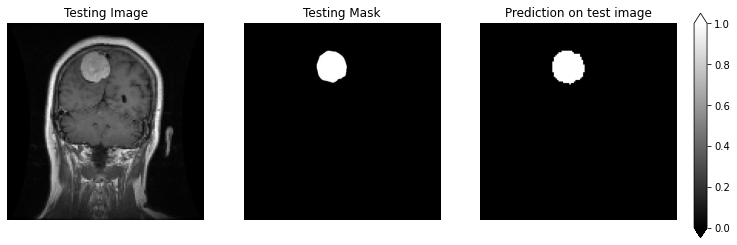

In [ ]:
# predicts random images from test images

test_img_number = random.randint(0, len(test_x) - 1)
test_img = test_x[test_img_number]
test_mask = test_y[test_img_number]
test_mask = plt.imread(test_mask, 0)
test_img = cv2.imread(test_img, 0)
test_img = test_img.astype(np.uint8)
test_img = cv2.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
test_img = cv2.merge([test_img, test_img, test_img])
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = model.predict(test_img_input)
test_pred1 = np.squeeze(test_pred1, axis=-1)
test_pred1= test_pred1 >= 0.5
test_pred1 = test_pred1.astype(np.int32)

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask, cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_pred1.squeeze(0), cmap = 'gray')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

The `save_results` function saves the input image, ground truth mask, and predicted mask side by side as a single image. It processes the masks, creates white separator lines, concatenates the images horizontally, and saves the resulting image to the specified file path.

In [ ]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((IMG_HEIGHT, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

We need to write a function that performs prediction and evaluation of a model on a test dataset:

- Iterates through pairs of test images and their corresponding masks.
- Preprocesses the images and masks, and predicts the mask using the model.
- Saves the input image, ground truth mask, and predicted mask as a single image.
- Calculates the evaluation metrics (F1 score, Jaccard index, Recall, and Precision) for each image-mask pair.
- Appends the image name and metric values to the `SCORE` list for further analysis.

In [ ]:
# Prediction and Evaluation the model on th test dataset
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    #Extracting the name from the image path
    name = x.split("/")[-1]

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) 
    x = image
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Prediction
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the prediction as image
    path='output_results/'
    save_image_path = os.path.join(path, name)
    save_results(image, mask, y_pred, save_image_path)

    # Flatten the array
    mask = mask
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    # Calculating the metrics values
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

100%|██████████| 153/153 [01:02<00:00,  2.45it/s]


Fucntion below calculates, prints, and saves the average evaluation metrics for a dataset:

- Extracts and averages the evaluation metrics from the `SCORE` list.
- Prints the F1 score, Jaccard index, Recall, and Precision with 5 decimal places.
- Saves the evaluation metrics for each image in a CSV file named `score.csv` in the `output_results` directory.

In [ ]:
# print and save the metrics values
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

# save the results as csv file
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
#df.to_csv("output_results/score.csv")
df.to_csv("output_results/score.csv")

F1: 0.83158\
Jaccard: 0.73849\
Recall: 0.84524\
Precision: 0.84534

## Conclusions

- Our study evaluated the effectiveness of the Unet model for MRI segmentation, a widely used convolutional neural network architecture.
- We split our MRI dataset into 85% for training, 10% for testing, and 5% for validation to evaluate the performance of the Unet model.
- The Unet model's encoder-decoder structure with skip connections is well-suited for MRI segmentation, enabling it to accurately identify regions of interest, such as tumors, within MRI scans.
- We evaluated the performance of our Unet model using the Dice coefficient, which measures the similarity between predicted and ground truth segmentation masks.
- Our Unet model achieved a high Dice coefficient score of 80%, indicating its superior performance in MRI segmentation.
- Accurate MRI segmentation using the Unet model can assist healthcare professionals in making more informed decisions and providing better treatment options to patients.
- Our findings suggest that the Unet model is an effective tool for accurate and reliable MRI segmentation, which can aid in the diagnosis and treatment of various medical conditions.
- Future studies can explore the use of other deep learning models or combine multiple models to improve the accuracy of MRI segmentation.
- The Unet model's superior performance in MRI segmentation is due to its ability to extract and integrate high-level and low-level features from input images.
- The Unet model is also widely used in other medical imaging applications, such as identifying lung nodules in CT scans and segmenting the heart in cardiac MRI scans.




